# Sentiment Analysis on Rotten Tomatoes Dataset II - Homework 2




testing / seb / joaquin / mikel

## Metrics Functions to Consider

1. **Accuracy**: Measures the proportion of correct predictions among the total number of cases examined. It's a straightforward metric but can be misleading if the classes are imbalanced.

2. **Precision and Recall**: Precision measures the proportion of positive identifications that were actually correct, while recall measures the proportion of actual positives that were identified correctly. These metrics are especially important when dealing with imbalanced datasets.

3. **F1 Score**: The harmonic mean of precision and recall. It's a good way to show that a classifer has a good balance between precision and recall.

4. **Confusion Matrix**: A table used to describe the performance of a classification model on a set of test data for which the true values are known. It allows the visualization of the performance of an algorithm.

5. **ROC and AUC**: The receiver operating characteristic curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system. The area under the curve (AUC) represents measure of separability.

In [ ]:
import tensorflow
print(tensorflow.__version__)
import transformers
print(transformers.__version__)
import datasets
print(datasets.__version__)

2.15.0
4.37.2
2.18.0


In [ ]:
#nltk.download('stopwords')
#!python -m spacy download en_core_web_sm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 31.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

#Preprocessing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
import spacy
import pickle
sp = spacy.load('en_core_web_sm')
import re
from tqdm import tqdm
tqdm.pandas()



#getting a library of stopwords and defining a lemmatizer
porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

class Metrics:
    def __init__(self):
        self.results = {}

    def run(self, y_true, y_pred, method_name, average='macro'):
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average=average)
        recall = recall_score(y_true, y_pred, average=average)
        f1 = f1_score(y_true, y_pred, average=average)

        # Store results
        self.results[method_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }

    def plot(self):
        # Create subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))

        # Plot each metric
        for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
            ax = axs[i//2, i%2]
            values = [res[metric] * 100 for res in self.results.values()]
            ax.bar(self.results.keys(), values)
            ax.set_title(metric)
            ax.set_ylim(0, 100)

            # Add values on the bars
            for j, v in enumerate(values):
                ax.text(j, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()


######### Additional Functions

#Returns words without any special
def strip(word):
    mod_string = re.sub(r'\W+', '', word)
    return mod_string

#the following leaves in place two or more capital letters in a row
#will be ignored when using standard stemming
def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

#modular pipeline for stemming, lemmatizing and lowercasing
#note this is NOT lemmatizing using grammar pos

def tokenize(text, modulation):
    stop_words.add('MODERATOR')
    if modulation<2:
        tokens = re.split(r'\W+', text)
        stems = []
        # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
        for token in tokens:
            lowers=abbr_or_lower(token)
            if lowers not in stop_words:
                if re.search('[a-zA-Z]', lowers):
                    if modulation==0:
                        stems.append(lowers)
                    if modulation==1:
                        stems.append(porter.stem(lowers))
    else:
        sp_text=sp(text)
        stems = []
        lemmatized_text=[]
        for word in sp_text:
            lemmatized_text.append(word.lemma_)
        stems = [abbr_or_lower(strip(w)) for w in lemmatized_text if (abbr_or_lower(strip(w))) and (abbr_or_lower(strip(w)) not in stop_words)]
    return " ".join(stems)


def txtprocess_tok(corpus,col,mod):
    text_preproc = (
    corpus[col]
    .astype(str)
    .progress_apply(lambda row: tokenize(row, mod))
    )
    return text_preproc


def vectorize(tokens, vocab):
    vector=[]
    for w in vocab:
        vector.append(tokens.count(w))
    return vector



LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


## Part 1 - Fine tuning BERT models

In this part, we will create a baseline model for text classification with BERT. This involves:

### 1. **Loading and Exploring Data**:

We will load the AG News corpus and perform necessary preprocessing steps like exploring the dataset.

In [ ]:
!pip install datasets transformers==4.37.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2


In [ ]:
from datasets import load_dataset

# Load the 'ag_news' dataset
df = load_dataset("rotten_tomatoes")

# Explore the structure of the dataset
print(df)

ModuleNotFoundError: No module named 'datasets'

Defining Train, Validation and Test datasets

In [ ]:
## Defining train, validation and test sets
train_data = df['train']['text']
train_labels = df['train']['label']

validation_data = df['validation']['text']
validation_labels = df['validation']['label']

test_data = df['test']['text']
test_labels = df['test']['label']

### **Training DistilBert Model**:

BERT-like Model Training (3 points)

- Objective: Train a BERT-like model (BERT, DistilBERT, xtremedistill, etc.) on the Rotten Tomatoes dataset with a softmax layer on top of embeddings.

- Tasks:
1. Train the Model (1 point): Train your chosen model on the dataset and calculate accuracy, precision, recall, and F1-score.
2. Error Analysis (1 point): Analyze false positives and false negatives to identify potential improvements.
3. Feature Engineering (1 point): Implement your proposed improvements based on error analysis and show the impact on model performance.


In [ ]:
from transformers import AutoTokenizer, TFAutoModel
transformers.__version__

checkpoint= "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModel.from_pretrained(checkpoint)

batch_size=64
max_length=64
rate = 0.5
num_labels = len(np.unique(validation_labels))

NameError: name 'transformers' is not defined

The architecture is:
1. Inputs ids and Inputs Masks
2. Embedding layer --> the BERT model to process the inputs
3. A layer upon the embeddings layer to convert the final [CLS] token into probabilities.

In [ ]:
import tensorflow as tf

## Input
input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32')

# Embedding layers
embedding_layer = model(input_ids=input_ids_in, attention_mask=input_masks_in)
# we need only the first token representation nothing else from the last layer!
final_embedding_layer = embedding_layer[0]#last layer of BERT
# Extract only the [CLS] token's embeddings
cls_token_embeddings = final_embedding_layer[:, 0, :]

output_layer = tf.keras.layers.Dropout(rate, name='do_layer')(cls_token_embeddings)

# One dense layer to process the last layer
output = tf.keras.layers.Dense(num_labels,
                               kernel_initializer="glorot_uniform",
                               activation='softmax')(output_layer)


bert_model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)

bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 64)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 64)]                 0         []                            
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6636288   ['input_token[0][0]',         
 stilBertModel)              den_state=(None, 64, 768),   0          'masked_token[0][0]']        
                              hidden_states=None, atten                                           
                             tions=None)                                                      

Let's generate some batches.

In [ ]:
from sklearn.utils import shuffle

def get_batches(X_train, y_train, tokenizer, batch_size, max_length):
    """
    Objective: Create a generator that yields batches of tokenized text and corresponding labels.
               The data is shuffled and looped through indefinitely.

    Inputs:
        - X_train (np.array): Array of text data (features).
        - y_train (np.array): Array of labels.
        - tokenizer (DistilBertTokenizer): Tokenizer for text data.
        - batch_size (int): Size of each batch.
        - max_length (int): Maximum length of tokenized sequences.
    Outputs:
        - Generator yielding batches of (inputs, targets).
    """

    # Pre-tokenize the entire dataset
    inputs = tokenizer.batch_encode_plus(list(X_train), add_special_tokens=True, max_length=max_length,
                                         padding='max_length', return_attention_mask=True,
                                         return_token_type_ids=True, truncation=True,
                                         return_tensors="np")

    input_ids = np.asarray(inputs['input_ids'], dtype='int32')
    attention_masks = np.asarray(inputs['attention_mask'], dtype='int32')

    # Shuffle and yield batches
    while True:
        X_train, y_train, input_ids, attention_masks = shuffle(X_train, y_train, input_ids, attention_masks, random_state=11)

        for i in range(0, len(X_train), batch_size):
            yield [input_ids[i:i + batch_size], attention_masks[i:i + batch_size]], y_train[i:i + batch_size]

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(np.array(train_labels).reshape(-1, 1)).toarray()

In [ ]:
from tensorflow.keras.optimizers import Adam

X_train = np.array(train_data)

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

bert_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                   tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

bert_model.fit(batches, epochs=10, steps_per_epoch=steps_per_epoch)

Epoch 1/10
133/133 [==============================] - 79s 370ms/step - loss: 0.4886 - recall: 0.7539 - precision: 0.7539
Epoch 2/10
133/133 [==============================] - 51s 382ms/step - loss: 0.3049 - recall: 0.8737 - precision: 0.8737
Epoch 3/10
133/133 [==============================] - 52s 389ms/step - loss: 0.1942 - recall: 0.9233 - precision: 0.9233
Epoch 4/10
133/133 [==============================] - 52s 389ms/step - loss: 0.1081 - recall: 0.9609 - precision: 0.9609
Epoch 5/10
133/133 [==============================] - 52s 389ms/step - loss: 0.0615 - recall: 0.9777 - precision: 0.9777
Epoch 6/10
133/133 [==============================] - 52s 388ms/step - loss: 0.0331 - recall: 0.9884 - precision: 0.9884
Epoch 7/10
133/133 [==============================] - 52s 389ms/step - loss: 0.0207 - recall: 0.9926 - precision: 0.9926
Epoch 8/10
133/133 [==============================] - 52s 389ms/step - loss: 0.0247 - recall: 0.9913 - precision: 0.9913
Epoch 9/10
133/133 [============

34/34 [==============================] - 4s 70ms/step


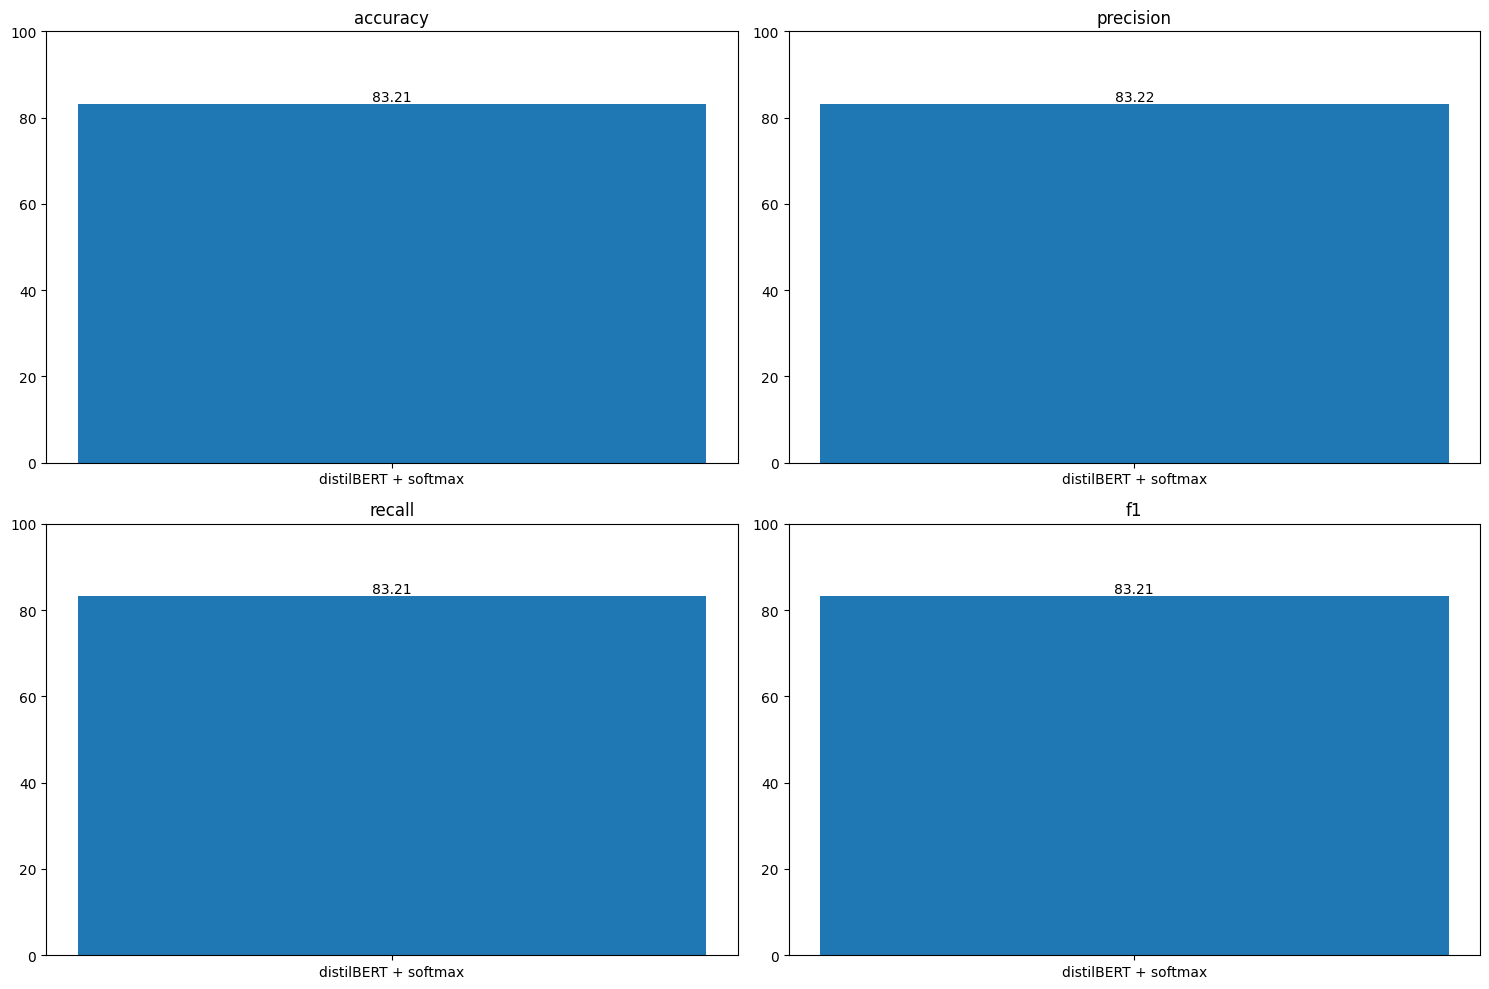

In [ ]:
# Get the inputs tokenized from the validation set
inputs = tokenizer.batch_encode_plus(list(validation_data),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_valid = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
valid_preds = bert_model.predict(inputs_valid)
valid_preds = np.argmax(valid_preds, axis=1)

# get the final metrics
metrics_val= Metrics()
metrics_val.run(validation_labels, valid_preds, "distilBERT + softmax")
metrics_val.plot()

Error Analysis (1 point): Analyze false positives and false negatives to identify potential improvements.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Assuming cm2 is your confusion matrix
cm = confusion_matrix(validation_labels, valid_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'positive'])
disp.plot(cmap='Blues')
plt.show()


NameError: name 'validation_labels' is not defined

### Error analysis

In [ ]:
### Error Analysis - Evaluate text wrongly classified in validation data
import pandas as pd

valid_df = pd.DataFrame({'review':validation_data,'label':validation_labels,'pred':valid_preds})

#Return only text where pred is different from label
valid_df_diff = valid_df[valid_df['label']!= valid_df['pred']]

#Reduce dimensionality
print(valid_df_diff.shape)
valid_df_diff.head()

(179, 3)


,review,label,pred
14,"the importance of being earnest , so thick wit...",1,0
16,"made for teens and reviewed as such , this is ...",1,0
17,imagine o . henry's <b>the gift of the magi</b...,1,0
22,nothing short of wonderful with its ten-year-o...,1,0
38,"broomfield reminds us that beneath the hype , ...",1,0


In [ ]:
## Text mining - Preprocessing, CountVectorizing and tf-idf
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

##Preprocessing Valdidation_diff text
valid_df_diff_pre = txtprocess_tok(valid_df_diff,'review',2)

100%|██████████| 179/179 [00:03<00:00, 44.80it/s]


In [ ]:
## Applying Pipeline
pipeline = Pipeline(
    [
        ("vect", CountVectorizer(ngram_range = (1,3),  min_df=0.05,max_df=0.9, stop_words='english')),
        ("tfidf", TfidfTransformer(use_idf=True, norm='l1')),
    ]
)

# Fit the pipeline to the validation data
pipeline.fit(validation_texts)

# Transform the validation data using the fitted pipeline
validation_tfidf = pipeline.transform(validation_texts)


Let's try to freeze the BERT models to see the differences and the knowlegde of BERT.

In [ ]:
import tensorflow as tf

## Input
input_ids_in =
input_masks_in =

# Embedding layers
# we need only the first token representation nothing else !
embedding_layer =
# Let's add some dropout to reduce overfitting
output_layer =

# One dense layer to process the last layer
output =


bert_model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)
bert_model.layers[2].trainable = False
bert_model.summary()

In [ ]:
batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)
#Compile the model with gradient descent algorithm and metrics
bert_model.compile(

)
#fit the model
bert_model

In [ ]:
valid_preds =
valid_preds =

metrics_val.run(valid_labels, valid_preds, "distilBERT frozen + Softmax")
metrics_val.plot()

## Part 2: Few Shot Learning

In this part, we'll explore few shot learning with SetFit. We will train the model with low number of examples and try to augment the dataset with prompts !

### Loading SetFit

Let's begin by setting-up the environment

In [ ]:
!pip install setfit

from setfit import SetFitModel, Trainer, TrainingArguments, sample_dataset

### Training the SetFit with 32 examples



In [ ]:
from datasets import Dataset

# Convert data into Dataset object from datasets
train_dict = {'text': train_data, 'label': train_labels}

train_dataset = Dataset.from_dict(train_dict)

dataset_dict = {'train': train_dataset}

#let's sample 32 examples at first to see results
train_dataset = sample_dataset(

                               )

train_dataset

In [ ]:
#Model to load
model = SetFitModel.from_pretrained(

)

#Arguments / hyperparamters to train
args = TrainingArguments(

)


# Trainer class to train afterwards
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset_augmented,
    metric="accuracy",
)

# Train and evaluate
trainer

In [ ]:
valid_preds =
metrics_val.run(valid_labels, valid_preds, "SetFit 32 examples")
metrics_val.plot()

### Try to augment the data with prompt

In [ ]:
labels = {0: 'World', 1: 'Sports',
          2: 'Business', 3: 'Sci/Tech'}
labels_to_id = {value:key for key, value in labels.items()}


from transformers import pipeline
# Load zero-shot classification pipeline
classifier =

# Define the sequence to classify
texts =

# Define the candidate labels
candidate_labels =

# Perform zero-shot classification
results =

In [ ]:
#select texts
texts =
#apply classifier
results =

In [ ]:
labels_to_id = {value:key for key, value in labels.items()}

new_texts = []
new_labels = []
th = 0.6

for text, result in zip(texts, results):
  if max(result.get('scores')) < th:
    continue

  new_texts.append(text)
  new_labels.append(labels_to_id.get(result.get('labels')[0]))

np.unique(new_labels, return_counts=True)

In [ ]:
train_data_augmented = train_dataset['text'] + new_texts
train_labels_augmented = train_dataset['label'] + new_labels

train_dict_augmented = {'text': train_data_augmented, 'label': train_labels_augmented}

train_dataset_augmented = Dataset.from_dict(train_dict_augmented)

train_dataset_augmented

In [ ]:

#Model to load
model = SetFitModel.from_pretrained(

)

#Arguments / hyperparamters to train
args = TrainingArguments(

)


# Trainer class to train afterwards
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset_augmented,
    metric="accuracy",
)

# Train and evaluate
trainer

### Model Evaluation

In [ ]:
#Makes some preds
valid_preds =
metrics_val.run(valid_labels, valid_preds, "SetFit augmented")
metrics_val.plot()

## Part 3: Winogender Schemas

In this work, we will explore biases of the BERT model. We will begin with the [Winograd Schemas adapted](https://en.wikipedia.org/wiki/Winograd_schema_challenge) to gender: [Winogender schemas](https://github.com/rudinger/winogender-schemas#winogender-schemas). This dataset is extracted from [Rudinger et al. (2018)](https://aclanthology.org/N18-2002/).


From Wikipedia:

> The Winograd schema challenge (WSC) is a test of machine intelligence proposed by Hector Levesque, a computer scientist at the University of Toronto. Designed to be an improvement on the Turing test, it is a multiple-choice test that employs questions of a very specific structure: they are instances of what are called Winograd schemas. Questions of this form may be tailored to require knowledge and commonsense reasoning in a variety of domains.
>
> A Winograd schema challenge question consists of three parts:
> 1. A sentence or brief discourse that contains the following:
> *   Two noun phrases of the same semantic class (male, female, inanimate or group of objects or people),
> *   An ambiguous pronoun that may refer to either of the above noun phrases, and
> *   A special word and alternate word, such that if the special word is replaced with the alternate word, the natural resolution of the pronoun changes.
> 2. A question asking the identity of the ambiguous pronoun, and
> 3. Two answer choices corresponding to the noun phrases in question.
>
> A machine will be given the problem in a standardized form which includes the answer choices, thus making it a binary decision problem.


In [ ]:
import pandas as pd

url = 'https://raw.githubusercontent.com/rudinger/winogender-schemas/master/data/templates.tsv'
df = pd.read_csv(url, sep='\t')

df.loc[:, 'whole_sentence'] = df.loc[:, ['sentence',
                                         'occupation(0)',
                                         'other-participant(1)']].apply(lambda x:
                                         x[0].replace('$OCCUPATION', x[1]).replace('$PARTICIPANT', x[2]), axis=1)

df.head()

### Gender bias identification

In this part, we will take a look at ungendered occupation / participant, and see what are the main distribution of gender pronouns.

We will use simp,ly the pipeline to fill mask from huggingface that is really efficient. We can do it for several different models in order to see what are the differences between models

#### BERT-large

In [ ]:
import re

checkpoint="bert-large-uncased"
classifier = pipeline('fill-mask', model=checkpoint)

regex = '\$(\w+)'
df.loc[:, 'pronoun'] = df.loc[:, 'whole_sentence'].apply(lambda x: re.findall(regex, x)[0])
words_to_replace = ['\$' + x for x in df.loc[:, 'pronoun'].unique()]
regex = r'(?:{})'.format('|'.join(words_to_replace))
df.loc[:, 'sentence_mask'] = df.loc[:, 'whole_sentence'].apply(lambda x: re.sub(regex, '[MASK]', x))
df.head()

In [ ]:
pronouns = {'ACC_PRONOUN': ['her', 'him'],
            'NOM_PRONOUN': ['she', 'he'],
            'POSS_PRONOUN': ['her', 'his']}

In [ ]:
res = {}
for key, value in pronouns.items():
  res[key] = []
  texts = list(df.loc[df.loc[:, 'pronoun'] == key, 'sentence_mask'].values)
  res[key] += classifier(texts, targets=value, top_k=2)

In [ ]:
probas = {}
for key, value in pronouns.items():
  probas[key] = [x[0]['score'] / (x[0]['score'] + x[1]['score'])
                 if x[0]['token_str'] == value[0]
                 else x[1]['score'] / (x[0]['score'] + x[1]['score'])
    for x in res[key]]

In [ ]:
for key, value in pronouns.items():
  df.loc[df.loc[:, 'pronoun'] == key, 'BERT-large-female'] = probas[key]

#### BERT

In [ ]:
checkpoint="bert-base-uncased"
classifier = pipeline('fill-mask', model=checkpoint)

res = {}
probas = {}
for key, value in pronouns.items():
  res[key] = []
  texts = list(df.loc[df.loc[:, 'pronoun'] == key, 'sentence_mask'].values)
  res[key] += classifier(texts, targets=value, top_k=2)
  probas[key] = [x[0]['score'] / (x[0]['score'] + x[1]['score'])
                 if x[0]['token_str'] == value[0]
                 else x[1]['score'] / (x[0]['score'] + x[1]['score'])
    for x in res[key]]
  df.loc[df.loc[:, 'pronoun'] == key, 'BERT-female'] = probas[key]

### distillBERT



In [ ]:
checkpoint="distilbert-base-uncased"
classifier = pipeline('fill-mask', model=checkpoint)

res = {}
probas = {}
for key, value in pronouns.items():
  res[key] = []
  texts = list(df.loc[df.loc[:, 'pronoun'] == key, 'sentence_mask'].values)
  res[key] += classifier(texts, targets=value, top_k=2)
  probas[key] = [x[0]['score'] / (x[0]['score'] + x[1]['score'])
                 if x[0]['token_str'] == value[0]
                 else x[1]['score'] / (x[0]['score'] + x[1]['score'])
    for x in res[key]]
  df.loc[df.loc[:, 'pronoun'] == key, 'distilBERT-female'] = probas[key]

#### Visualize

In [ ]:
probas = {}

for occ, part, answer, l, b, d in df.loc[:, ['occupation(0)', 'other-participant(1)', 'answer',
                                             'BERT-large-female', 'BERT-female', 'distilBERT-female']].values:
  p = occ if answer == 0 else part
  if p in probas.keys():
    probas[p].append([l, b, d])
  else:
    probas[p] = [[l, b, d]]

for key, value in probas.items():
  probas[key] = np.mean(value, axis=0)

probas = sorted(probas.items(), key=lambda x: x[1][0], reverse=True)

In [ ]:
fig, ax = plt.subplots(figsize=(30, 8))

ax.scatter(np.arange(len(probas)), [x[1][0] for x in probas], label='BERT-large')
ax.scatter(np.arange(len(probas)), [x[1][1] for x in probas], label='BERT')
ax.scatter(np.arange(len(probas)), [x[1][2] for x in probas], label='distilBERT')

ax.hlines(0.5, 0, len(probas), colors='g')
ax.set_xticks(np.arange(len(probas)))
ax.set_xticklabels([x[0] for x in probas], rotation=90)
ax.set_xlabel("occupations")
ax.set_ylabel("probability to be women")
ax.legend()

plt.show()

In [ ]:
CHANGESSSSSS CHANGESSSS